In [1]:
import ee, geemap
from itertools import product

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()


In [2]:
# pip install folium shapely
import folium
from shapely.geometry import Polygon



okavango = [
    (21.7, -18.2),
    (21.7, -20.3),
    (23.6, -20.3),
    (23.6, -18.2),
]



poly = Polygon(okavango)
# Center map on polygon centroid (lat, lon order for Folium!)
lat, lon = poly.centroid.y, poly.centroid.x
m = folium.Map(location=[lat, lon], zoom_start=7, tiles="CartoDB positron")

# Folium wants [lat, lon] pairs; convert
coords_latlon = [(y, x) for x, y in okavango] + [(okavango[0][1], okavango[0][0])]
folium.Polygon(
    locations=coords_latlon,
    color="red",
    weight=3,
    fill=True,
    fill_opacity=0.2,
    tooltip="Okavango study area",
).add_to(m)

m


### Load Landsat DSWE ImageCollection

In [3]:

def list_image_ids(path: str):
    """
    return IDs of image assets under an Earth Engine path (filters out folders/collections)
    """
    assets = ee.data.listAssets(path).get('assets', [])
    return [a['id'] for a in assets if a.get('type') == 'IMAGE']

def list_ids(path: str):
    """
    return IDs of all assets under an Earth Engine path (filters out folders/collections)
    """
    assets = ee.data.listAssets(path).get('assets', [])
    return [a['id'] for a in assets]


# landsat monthly DSWE
ls_dswe_path = 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products'
ls_dswe_ids  = list_image_ids(ls_dswe_path)
ls_dswe_ids[:10]


['projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_06',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_07',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_09',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_10',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_11',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1985_04',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1986_11',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1986_12',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1987_01',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1987_02']

In [4]:
def load_landsat_dswe(id):
    """
    Load Landsat DSWE image by asset ID, add a binary water mask, and tag date metadata.
    """
    year = ee.String(id).split('_').get(-2)
    month = ee.String(id).split('_').get(-1)
    img = ee.Image(id)
    binary = img.gt(0).toFloat().rename('dswe_bin')
    return img.addBands(binary).set({'year': year, 
            'month': month, 'date': ee.String(year).cat('-').cat(month)})

ls_dswe_collection = ee.ImageCollection([load_landsat_dswe(id) for id in ls_dswe_ids])
print (ls_dswe_collection.first().getInfo()['bands'])

[{'id': 'dswe', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [8320, 7112], 'crs': 'EPSG:4326', 'crs_transform': [0.00026949458523585647, 0, 21.791062667586118, 0, -0.00026949458523585647, -18.269307427723945]}, {'id': 'dswe_bin', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8320, 7112], 'crs': 'EPSG:4326', 'crs_transform': [0.00026949458523585647, 0, 21.791062667586118, 0, -0.00026949458523585647, -18.269307427723945]}]


In [5]:
# Define palettes visualization parameters
palettes = {
    # sequential light→dark blues (ordered magnitudes; ColorBrewer "Blues"-like)
    "dswe_classes": ["white", "#deebf7", "#9ecae1", "#3182bd"],   # 1..4

    # binary white vs blue (crisp on dark/imagery basemaps)
    "dswe_binary":  ["white", "#3182bd"],                         # 0/1

    # zero-centered diverging brown↔teal with light neutral midpoint
    # (good for values around 0: residuals, anomalies, signed ratios)
    "centered":     ["#a6611a", "#dfc27d", "#f5f5f5", "#80cdc1", "#018571"],  # -1..1

    # classic diverging red↔white↔blue
    "diff_rwb":     ["#ef8a62", "#f7f7f7", "#67a9cf"]
}


vis_dswe_classes = {
    "palette": palettes["dswe_classes"],
    "min": 1,
    "max": 4
}

vis_dswe_binary = {
    "palette": palettes["dswe_binary"],
    "min": 0,
    "max": 1
}

vis_centered = {
    "palette": palettes["centered"],
    "min": -1,
    "max": 1
}

vis_diff_rwb = {
    "palette": palettes["diff_rwb"],
    "min": -1,
    "max": 1
}


In [6]:
#   Filters for year-specific and seasonal averages,
# Subset DSWE for comparison to Inman Lyons
#  TODO: check that DSWE and IL years match
dswe_compare = ls_dswe_collection  \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lt('year', '2025')) \

# Compute decade composites for DSWE
dswe_1990s = ls_dswe_collection \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month',  '07')) \
    .filter(ee.Filter.gte('year', '1985')) \
    .filter(ee.Filter.lte('year', '2005')) \
    .mean()

dswe_2010s = ls_dswe_collection \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('year', '2020')) \
    .filter(ee.Filter.lte('year', '2025')) \
    .mean()

dswe_change = dswe_2010s.subtract(dswe_1990s)


In [7]:
# --- export change image export 
run_exports = False

task_change = ee.batch.Export.image.toDrive(
    image=(
        dswe_change
        .select('dswe')                
        .unmask(0)
        .updateMask(dswe_1990s.select('dswe').eq(0))  
        .visualize(**vis_centered)     # use centered scheme for change
    ),
    description='DSWE_change_2010s_vs_1990s',
    folder='Okavango',
    fileNamePrefix='DSWE_change_2010s_vs_1990s',
    region=okavango,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)

if run_exports:
    task_change.start()
else:
    print("Export created but not started")

Export created but not started


## Load Sentinel DSWE ImageCollection

In [9]:
sent2_dswe_path = 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products'
sent2_dswe_ids  = list_image_ids(sent2_dswe_path)
sent2_dswe_ids[:10]

['projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_12',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_01',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_02',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_03',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_04',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_05',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_06',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_07',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_08',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_09']

In [10]:
def load_s2_dswe(id):
    """
    Load sentinel DSWE image by asset ID, add a binary water mask, and tag date metadata.
    """    
    year = ee.String(id).split('_').get(-2)
    month = ee.String(id).split('_').get(-1)
    img = ee.Image(id)
    binary = img.gt(0).toFloat().rename('DSWE_bin')
    return img.addBands(binary).set({'year': year, 'month': month, 'date': ee.String(year).cat('-').cat(month)})

s2_dswe = ee.ImageCollection([load_s2_dswe(id) for id in sent2_dswe_ids])
print (s2_dswe.first().getInfo()['properties']['year'])


# Filters to months used in IL 
s2_dswe_compare = s2_dswe \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lt('year', '2025')) \


# mean DSWE visualization export (10 m)
task_s2_mean = ee.batch.Export.image.toDrive(
    image = s2_dswe_compare.select('DSWE').mean().selfMask().visualize(**vis_dswe_classes),
    description    = 'DSWE_sentinel_mean_JulSep5',
    folder         = 'Okavango',
    fileNamePrefix = 'DSWE_sentinel_mean_JulSep',
    region         = okavango,
    scale          = 10,
    crs            = 'EPSG:4326',
    maxPixels      = 1e13
)



if run_exports:
    task_s2_mean.start()
    print("Started export: DSWE_sentinel_mean_JulSep")
else:
    print("Created export, not started: DSWE_sentinel_mean_JulSep")

2018
Created export, not started: DSWE_sentinel_mean_JulSep


In [11]:
def view_tasks(limit=10):
    """Print the first `limit` Earth Engine tasks with key metadata."""
    ops = ee.data.listOperations()[:limit]
    if not ops:
        print("No tasks found.")
    for i, op in enumerate(ops, 1):
        meta = op.get('metadata', {}) or {}
        state   = meta.get('state', '')
        desc    = meta.get('description', '(no desc)')
        create  = meta.get('createTime', '')
        update  = meta.get('updateTime', '')
        task_id = op.get('name', '')
        print(f"{i:2d}. {state:8}  {desc}")
        print(f"    id: {task_id}")
        print(f"    created: {create} | updated: {update}")


def cancel_tasks(limit=10, states=('READY','RUNNING','PENDING')):
    """Cancel the first `limit` tasks matching given states."""
    for op in ee.data.listOperations()[:limit]:
        meta = op.get('metadata', {}) or {}
        state = meta.get('state', '')
        name  = op.get('name', '')
        desc  = meta.get('description', '(no desc)')
        if state in states:
            ee.data.cancelOperation(name)
            print(f"Canceled: {desc} ({state})")
# see what’s queued
view_tasks(limit=10)

# cancel any READY/RUNNING tasks
# cancel_tasks(limit=5)

 1. SUCCEEDED  CanopySlopeFilter
    id: projects/ee-okavango/operations/QXTIKDYYVZYNKAUF767NJIE7
    created: 2025-10-02T14:57:35.867300Z | updated: 2025-10-02T15:02:44.138669Z
 2. SUCCEEDED  CanopySlopeFilter
    id: projects/ee-okavango/operations/ILOBRR2HLF4O3GZLN4WYIWLA
    created: 2025-10-02T14:42:55.165442Z | updated: 2025-10-02T14:49:57.266265Z
 3. SUCCEEDED  HLS_S30_samples_Bolivia_first100
    id: projects/ee-okavango/operations/P64GKRBDT4FU2JVIBGJBYN3W
    created: 2025-10-02T00:00:22.812597Z | updated: 2025-10-02T00:00:47.501213Z
 4. SUCCEEDED  HLS_S30_samples_Bolivia_first100
    id: projects/ee-okavango/operations/NL5YIUFAWSMBMNSZ2QMVBO5Q
    created: 2025-10-01T23:52:25.282948Z | updated: 2025-10-01T23:52:37.540409Z
 5. SUCCEEDED  landsat_dswe_monthly_count
    id: projects/ee-okavango/operations/M6SB5BYCSKAQWA3L2UAF7MCX
    created: 2025-10-01T01:28:12.880113Z | updated: 2025-10-01T01:28:28.481171Z
 6. SUCCEEDED  landsat_dswe_monthly_count
    id: projects/ee-okavango/

In [12]:
def explain_task(task_id=None):
    """
    Print details (state, description, error) for a given task_id,
    or for the most recent FAILED task if task_id is None.
    """
    ops = ee.data.listOperations()
    if not ops:
        print("No tasks found."); return

    if task_id:
        op = next((o for o in ops if o.get('name') == task_id), None)
        print (len(op))
        if not op:
            print(f"No task with id {task_id}"); 
            return
    else:
        failed = [o for o in ops if o.get('metadata', {}).get('state') == 'FAILED']
        if not failed:
            print("No failed tasks."); return
        op = max(failed, key=lambda o: o.get('metadata', {}).get('updateTime',''))
#         print (op['error']['message'], len(op))

    meta = op.get('metadata', {}) or {}
    err  = op.get('error', {})
    msg  = err.get('message') if isinstance(err, dict) else err

    print(f"desc   : {meta.get('description','(no desc)')}")
    print(f"id     : {op.get('name')}")
    print(f"state  : {meta.get('state')}")
    print(f"error  : {msg}")

explain_task()




desc   : IL_2024
id     : projects/ee-okavango/operations/A6PANZXSDEBSCMKYJBBJOTH5
state  : FAILED
error  : Image.clip: The area for image clipping must be a geometry, a Feature or a FeatureCollection.


## Inman Lyons layers


 Inman and Lyons (2020) created their landcover/inundation maps using annual 
 Landsat composites from  July through September, the peak inundation period in
 the Okavango Delta.

 Composites are the median of all cloud/shadow-masked scenes in that window, 
 and gap-fill from ±1 year. Years with large gaps were dropped 
 (1993, 2000, 2009, 2010, 2012).
 For validation imagery, they inspected high-resolution images July–October 
 (broader than the composites) alongside the Landsat true-color composites.


In [14]:
def load_il_image(aid, band_name=None):
    """Load one Inman–Lyons image by asset id; optionally rename first band; tag 'year'."""
    img = ee.Image(aid)
    if band_name:
        img = img.select(0).rename(band_name)
    year = ee.String(aid).split('_').get(-1)
    return img.set({'year': year})

def load_il(path, band_name=None):
    """Load all IMAGE assets under a folder into an ImageCollection (client-side list)."""
    assets = ee.data.listAssets(path).get('assets', [])
    ids = [a['id'] for a in assets if a.get('type') == 'IMAGE']
    images = [load_il_image(i, band_name) for i in ids]  # build a Python list of ee.Image
    return ee.ImageCollection(images)


# --- IL collections ---
IL_collection = load_il('projects/ee-okavango/assets/Inman_Lyons/FloodArea')
IL_og         = load_il('projects/ee-okavango/assets/Inman_Lyons/Annual_inundation_maps',
                        band_name='SR_B7')
# prefer IL_og through 2018, then FloodArea
IL_merged     = IL_og.filter(ee.Filter.lt('year', '2019')).merge(IL_collection)  

# --- means & diffs (single-summary exports) ---
IL_mean      = IL_merged.mean()  # multi-year mean IL inundation
IL_mean_diff = IL_mean.subtract(dswe_compare.select('dswe_bin').mean()).rename('IL_minus_DSWE_mean')  # mean IL - mean DSWE


In [50]:
# # --- region (already have this above, included here for completeness) ---
okavango_rectangle = ee.Geometry.Polygon(
    [[[21.6, -18.2],
      [21.6, -20.],
      [24.1, -20.],
      [24.1, -18.2],
      [21.6, -18.2]]],
    None, False
)

okavango_fc = ee.FeatureCollection('projects/ee-okavango/assets/shapes/okavango_outline_20241031');

okavango_feat = ee.Feature(okavango_fc.first());
okavango = okavango_fc.geometry();


# 1) Load shapefile as EE FeatureCollection
shp_path = "../data/Delta_UCB_WGS84/Delta_UCB_WGS84.shp"  # <-- update
okavango_fc = geemap.shp_to_ee(shp_path)     # ee.FeatureCollection

# 2) Make a single, clean polygon geometry (union + buffer(0))
okavango = (okavango_fc
            .geometry()
            .dissolve(maxError=100)          
           )



In [20]:
# --- helper to add (date, count) properties to each image ---
def add_pixel_count(img):
    # count pixels with dswe_bin == 1 (i.e., DSWE > 0)
    count = (img.select('dswe_bin')
               .reduceRegion(ee.Reducer.sum(), okavango, scale=30, maxPixels=1e13)
               .get('dswe_bin'))

    # build a date from 'year' and 'month' image properties
    year  = ee.Number.parse(img.get('year'))
    month = ee.Number.parse(img.get('month'))  # '01'..'12' → number
    date  = ee.Date.fromYMD(year, month, 1)

    return img.set({'count': count, 'date': date.millis()})

# --- build the time series on the server ---
ts_ic = (ls_dswe_collection
         .sort('year')      # 'YYYY' strings are fine for lexicographic sort
         .sort('month')     # '01'..'12'
         .map(add_pixel_count))

# Option A: bring back as two arrays and print a small table (quick look)
dates_millis = ts_ic.aggregate_array('date').getInfo()
counts       = ts_ic.aggregate_array('count').getInfo()

from datetime import datetime, timezone
rows = []
for d, c in zip(dates_millis, counts):
    dt = datetime.fromtimestamp(d/1000, tz=timezone.utc).strftime('%Y-%m')
    rows.append((dt, int(c) if c is not None else None))

print("YYYY-MM, pixel_count_dswe_gt0")
for r in rows:
    print(*r, sep=", ")

# Convert to a FeatureCollection with date/count properties and export.
ts_fc = ee.FeatureCollection(
    ts_ic.map(lambda im: ee.Feature(None, {
        'date': ee.Date(ee.Number(im.get('date'))).format('YYYY-MM'),
        'count': im.get('count')
    }))
)

if run_exports:
    ee.batch.Export.table.toDrive(
        collection=ts_fc,
        description='landsat_dswe_monthly_count',
        folder='Okavango',
        fileNamePrefix='landsat_dswe_monthly_count',
        fileFormat='CSV'
    ).start()


YYYY-MM, pixel_count_dswe_gt0
1987-01, 3590227
1989-01, 6173610
1991-01, 3347874
1992-01, 3198614
1993-01, 2368296
1994-01, 3177007
1995-01, 1368397
1996-01, 1751145
1997-01, 2736909
1998-01, 2164589
1999-01, 2338436
2000-01, 3225111
2001-01, 1567792
2002-01, 2939366
2003-01, 1643972
2007-01, 3353932
2010-01, 5693972
2011-01, 2446976
2014-01, 4225915
2015-01, 2559390
2016-01, 1408849
2017-01, 3975163
2018-01, 1213328
2019-01, 1326124
2020-01, 1058538
2021-01, 5069770
2022-01, 1667237
2023-01, 1104677
2024-01, 1512132
2025-01, 3744692
1987-02, 3681920
1989-02, 7382628
1990-02, 2831342
1991-02, 5420411
1992-02, 3204311
1993-02, 3466769
1995-02, 2005215
1996-02, 2139450
1997-02, 2739437
1998-02, 1933180
1999-02, 2823491
2000-02, 4403196
2001-02, 2766701
2002-02, 2370852
2003-02, 2180912
2004-02, 5109829
2005-02, 3785556
2006-02, 6576569
2007-02, 4014114
2008-02, 6166615
2010-02, 6122111
2011-02, 2635811
2014-02, 4534574
2015-02, 2768343
2016-02, 1759465
2017-02, 6028031
2018-02, 1626048
2

In [21]:
import pandas as pd

def fc_to_dataframe(fc, props=('date','count'), limit=None):
    """
    Convert an ee.FeatureCollection to a pandas DataFrame.
    NOTE: Uses getInfo(); fine for small/medium tables.
    """
    fc_q = fc if limit is None else fc.limit(int(limit))
    info = fc_q.getInfo()
    rows = [{k: f['properties'].get(k) for k in props} for f in info['features']]
    df = pd.DataFrame(rows)
    # parse 'date' like 'YYYY-MM' if present
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m', errors='coerce')
    return df

df_ls = fc_to_dataframe(ts_fc, props=('date','count'))
print(df_ls.head())


        date         count
0 1987-01-01  3.590227e+06
1 1989-01-01  6.173610e+06
2 1991-01-01  3.347874e+06
3 1992-01-01  3.198615e+06
4 1993-01-01  2.368296e+06


In [22]:
# --- Sentinel-2 DSWE monthly pixel-count time series (DSWE > 0) ---

# Helper to attach (date, count) to each Sentinel-2 image
def add_pixel_count_s2(img):
    # If no DSWE_bin, use: gt0 = img.select('dswe').gt(0)
    gt0 = img.select('DSWE_bin')
    count = gt0.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=okavango,
        scale=10,
        maxPixels=1e13
    ).get(gt0.bandNames().get(0))  # fetch the band key safely

    year  = ee.Number.parse(img.get('year'))
    month = ee.Number.parse(img.get('month'))
    date  = ee.Date.fromYMD(year, month, 1)
    return img.set({'count': count, 'date': date.format('YYYY-MM')})

# Build the time series (server-side), sorted by year then month
ts_ic_s2 = (s2_dswe
            .sort('year')
            .sort('month')
            .map(add_pixel_count_s2))

# Convert to a FeatureCollection of {date, count}
ts_fc_s2 = ee.FeatureCollection(
    ts_ic_s2.map(lambda im: ee.Feature(None, {
        'date': im.get('date'),
        'count': im.get('count')
    }))
)

# ---- Pandas DataFrame (array-based, lightweight fetch) ----
import pandas as pd

dates_s2  = ts_fc_s2.aggregate_array('date').getInfo()
counts_s2 = ts_fc_s2.aggregate_array('count').getInfo()

df_s2 = pd.DataFrame({'date': dates_s2, 'count': counts_s2})
df_s2['date'] = pd.to_datetime(df_s2['date'], format='%Y-%m', errors='coerce')

print(df_s2.head())


        date         count
0 2019-01-01  6.776887e+06
1 2020-01-01  7.922782e+06
2 2021-01-01  3.135053e+07
3 2022-01-01  1.742858e+07
4 2023-01-01  6.067235e+06


In [23]:
# --- Inman & Lyons monthly pixel-count time series (values > 0) ---

IL_merged = IL_og.filter(ee.Filter.lte('year', '2019')).merge(IL_collection)
print (IL_merged.size().getInfo())
# keep IL_og only through 2019
il_og_pre2019 = IL_og.filter(ee.Filter.lte('year', '2019'))

# list of years already covered (as strings, distinct)
years_in_og = il_og_pre2019.aggregate_array('year').distinct()

# keep only those images in IL_Collection whose 'year' is not in years_in_og
# (ee.Filter.inList(...).Not() excludes matching years)
il_coll_missing_years = IL_collection.filter(
    ee.Filter.inList('year', years_in_og).Not()
)

# merge: first collection + only-missing-years from second
IL_merged = il_og_pre2019.merge(il_coll_missing_years)
print (IL_merged.size().getInfo())

43
30


In [24]:

# Helper: attach (date, count) for each IL image
def add_pixel_count_il(img):
    # Use the first band (IL products can have varying names); rename for consistency
    il = img.select(0).rename('il')
    gt0 = il.eq(1)  # treat >0 as inundated

    count = gt0.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=okavango,
        scale=30,          # IL maps are Landsat-derived (30 m)
        maxPixels=1e13
    ).get('il')

    # Build a date from the 'year' property; IL images are annual composites
    year = ee.Number.parse(img.get('year'))
    date = ee.Date.fromYMD(year, 1, 1)  # use Jan 1 of that year for a consistent timestamp

    return img.set({'count': count, 'date': date.format('YYYY-MM')})

# Build time series (sorted by year for readability)
ts_ic_il = (IL_merged
            .sort('year')
            .map(add_pixel_count_il))

# To FeatureCollection of {date, count}
ts_fc_il = ee.FeatureCollection(
    ts_ic_il.map(lambda im: ee.Feature(None, {
        'date': im.get('date'),
        'count': im.get('count')
    }))
)

# ---- Pandas DataFrame (array-based fetch) ----
import pandas as pd

dates_il  = ts_fc_il.aggregate_array('date').getInfo()
counts_il = ts_fc_il.aggregate_array('count').getInfo()

df_il = pd.DataFrame({'date': dates_il, 'count': counts_il})
df_il['date'] = pd.to_datetime(df_il['date'], format='%Y-%m', errors='coerce')

print(df_il.head())


        date         count
0 1990-01-01  8.406320e+06
1 1991-01-01  8.087729e+06
2 1992-01-01  8.733517e+06
3 1994-01-01  6.585254e+06
4 1995-01-01  6.036016e+06


In [25]:
img = IL_collection.first()  # or a specific year image
hist = img.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=okavango,
    scale=30,
    maxPixels=1e13
)
print(hist.getInfo())  # inspect keys 0,1,2,3 and their counts
print(img.bandNames().getInfo())

{'SR_B7': {'0': 19672677.729411766, '1': 4923978.313725491}}
['SR_B7']


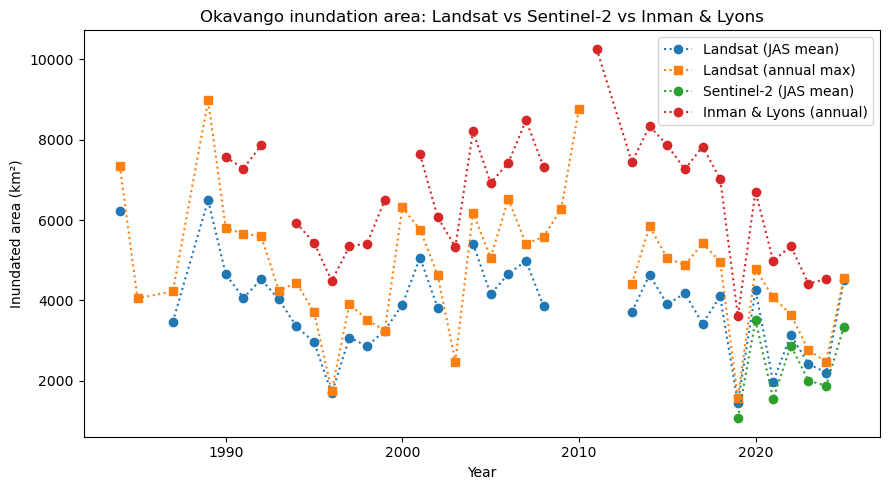

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

PX30_TO_KM2 = 0.0009  # 30 m pixel area in km²

def jas_annual_mean(df: pd.DataFrame, label: str, value_col: str = 'area_km2'):
    """Return ['year', f'{label}_jas_mean_km2'] as July–September mean of `value_col`."""
    out = df.copy()
    out['date']  = pd.to_datetime(out['date'], errors='coerce')
    out['year']  = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out = out[out['month'].isin([7, 8, 9])]
    ann = (out.groupby('year', as_index=False)[value_col]
              .mean()
              .rename(columns={value_col: f'{label}_jas_mean_km2'}))
    return ann

def annual_max(df: pd.DataFrame, label: str, value_col: str = 'area_km2'):
    """Return ['year', f'{label}_jas_mean_km2'] as July–September mean of `value_col`."""
    out = df.copy()
    out['date']  = pd.to_datetime(out['date'], errors='coerce')
    out['year']  = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out = out[out['month'].isin([4,5,6,7, 8, 9, 10])]
    ann = (out.groupby('year', as_index=False)[value_col]
              .max()
              .rename(columns={value_col: f'{label}_max_km2'}))
    return ann

# 1) Landsat: pixels -> km²
df_ls_km2 = df_ls.copy()
df_ls_km2['area_km2'] = df_ls_km2['count'] * PX30_TO_KM2
ls_ann = jas_annual_mean(df_ls_km2, label='landsat')

ls_max = annual_max(df_ls_km2, label='landsat')


# 2) Sentinel-2: convert to 30 m-pixel equivalents (÷9), then -> km²
df_s2_km2 = df_s2.copy()
df_s2_km2['area_km2'] = (df_s2_km2['count'] / 9.0) * PX30_TO_KM2
s2_ann = jas_annual_mean(df_s2_km2, label='sentinel')

# 3) Inman & Lyons (30 m): pixels -> km², then annual mean (already annual timestamps)
df_il_km2 = df_il.copy()
df_il_km2['date'] = pd.to_datetime(df_il_km2['date'], errors='coerce')
df_il_km2['year'] = df_il_km2['date'].dt.year
il_ann = (df_il_km2.assign(area_km2=df_il_km2['count'] * PX30_TO_KM2)
                    .groupby('year', as_index=False)['area_km2']
                    .mean()
                    .rename(columns={'area_km2': 'il_annual_km2'}))

# Combine and plot
annual_km2 = (ls_ann.merge(ls_max, on='year', how='outer')
                    .merge(s2_ann, on='year', how='outer')
                    .merge(il_ann, on='year', how='outer')
                    .sort_values('year')
                    .reset_index(drop=True))

plt.figure(figsize=(9, 5))
plt.plot(annual_km2['year'], annual_km2['landsat_jas_mean_km2'], marker='o', linestyle = ":", label='Landsat (JAS mean)')
plt.plot(annual_km2['year'], annual_km2['landsat_max_km2'], marker='s', linestyle = ":", label='Landsat (annual max)')
plt.plot(annual_km2['year'], annual_km2['sentinel_jas_mean_km2'], marker='o', linestyle = ":", label='Sentinel-2 (JAS mean)')
plt.plot(annual_km2['year'], annual_km2['il_annual_km2'],        marker='o', linestyle = ":", label='Inman & Lyons (annual)')
plt.xlabel('Year'); plt.ylabel('Inundated area (km²)')
plt.title('Okavango inundation area: Landsat vs Sentinel-2 vs Inman & Lyons')
plt.legend(); plt.tight_layout(); plt.show()


In [97]:
annual_km2.corr().round(2)['il_annual_km2']

year                    -0.13
landsat_jas_mean_km2     0.91
landsat_max_km2          0.54
sentinel_jas_mean_km2    0.92
il_annual_km2            1.00
Name: il_annual_km2, dtype: float64

In [90]:
annual_km2.to_csv("annual_flood_area_km2.csv")

Missing months (Landsat): ['2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09'] … total 81
Missing months (Sentinel): ['2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09'] … total 81


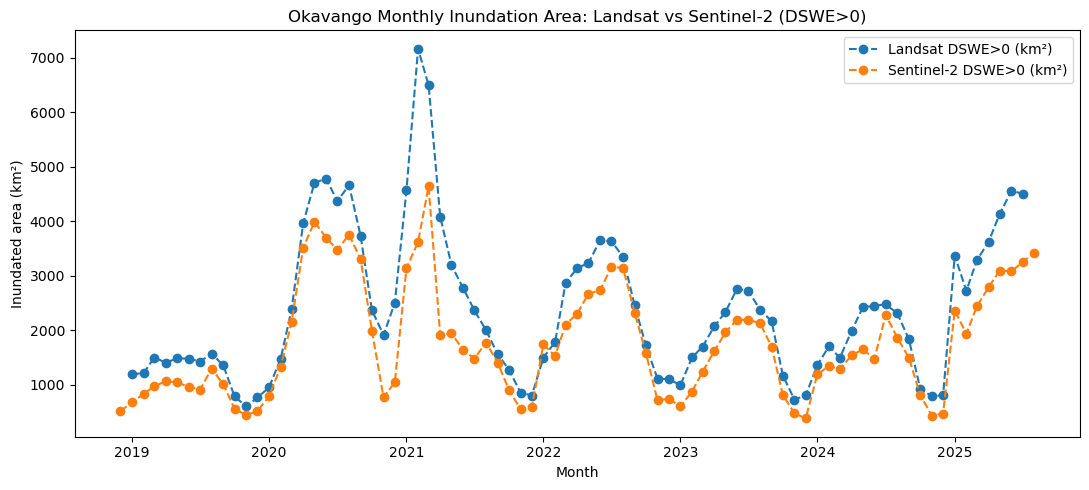

In [30]:

PX30_TO_KM2 = 0.0009  # 30 m pixel area in km²

def prep_monthly(df: pd.DataFrame, sensor: str):
    """
    From a monthly df with ['date','count'], return a monthly series in km²:
      - Landsat: count * 0.0009
      - Sentinel-2: (count / 9) * 0.0009
    Aggregates by month (mean if multiple rows per month).
    """
    out = df[['date','count']].copy()
    out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out = out.dropna(subset=['date'])
    out['month'] = out['date'].dt.to_period('M').dt.to_timestamp()
    out['year'] = out['date'].dt.to_period('Y').dt.to_timestamp()    

    if sensor == 'landsat':
        out['km2'] = out['count'] * PX30_TO_KM2
    elif sensor == 'sentinel':
        out['km2'] = (out['count'] / 9.0) * PX30_TO_KM2
    else:
        raise ValueError("sensor must be 'landsat' or 'sentinel'")

    # average if multiple entries in a month
    return (out.groupby('month', as_index=True)[['km2','year']]
               .mean()
               .sort_index())

# Build monthly series
ls_monthly = prep_monthly(df_ls, sensor='landsat').query('year > 2018')
s2_monthly = prep_monthly(df_s2, sensor='sentinel')

# Create a complete monthly index spanning both series
start = min(ls_monthly.index.min(), s2_monthly.index.min())
end   = max(ls_monthly.index.max(), s2_monthly.index.max())
full_months = pd.date_range(start=start, end=end, freq='MS')  # month starts

ls_full = ls_monthly.reindex(full_months)
s2_full = s2_monthly.reindex(full_months)

# list missing months (where either is NaN)
missing_ls = ls_full[ls_full.isna()].index.strftime('%Y-%m').tolist()
missing_s2 = s2_full[s2_full.isna()].index.strftime('%Y-%m').tolist()
print("Missing months (Landsat):", missing_ls[:10], "… total", len(missing_ls))
print("Missing months (Sentinel):", missing_s2[:10], "… total", len(missing_s2))

# Plot monthly DSWE area (km²), dashed lines with markers
plt.figure(figsize=(11, 5))
plt.plot(ls_full.index, ls_full['km2'], marker='o', linestyle='--', label='Landsat DSWE>0 (km²)')
plt.plot(s2_full.index, s2_full['km2'], marker='o', linestyle='--', label='Sentinel-2 DSWE>0 (km²)')
plt.xlabel('Month')
plt.ylabel('Inundated area (km²)')
plt.title('Okavango Monthly Inundation Area: Landsat vs Sentinel-2 (DSWE>0)')
plt.legend()
plt.tight_layout()
plt.show()


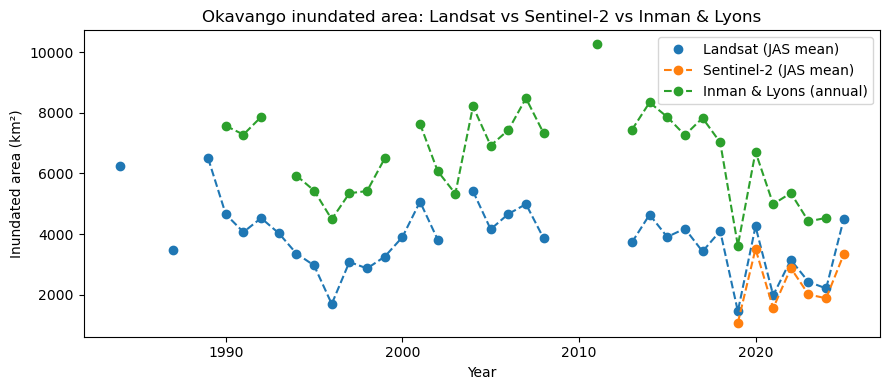

In [32]:
# Pick a clear, color-blind friendly palette
COLORS = {
    'Landsat (JAS mean)':        'C0',
    'Sentinel-2 (JAS mean)':     'C1',
    'Inman & Lyons (annual)':    'C2',
}

def plot_gapped(years, values, label, marker='o', linestyle='--', color=None):
    years = list(years); values = list(values)
    seg_x, seg_y, prev_year, segments = [], [], None, []

    for y, v in zip(years, values):
        if pd.isna(v):
            if seg_x: segments.append((seg_x, seg_y))
            seg_x, seg_y, prev_year = [], [], None
            continue
        if prev_year is None or y != prev_year + 1:
            if seg_x: segments.append((seg_x, seg_y))
            seg_x, seg_y = [y], [v]
        else:
            seg_x.append(y); seg_y.append(v)
        prev_year = y
    if seg_x: segments.append((seg_x, seg_y))

    for x, y in segments:
        if len(x) == 1:
            plt.plot(x, y, marker=marker, linestyle='none', color=color, label=label)
        else:
            plt.plot(x, y, marker=marker, linestyle=linestyle, color=color, label=label)
        label = None  # avoid duplicate legend entries

plt.figure(figsize=(9, 4))
plot_gapped(annual_km2['year'], annual_km2['landsat_jas_mean_km2'],
            'Landsat (JAS mean)',        color=COLORS['Landsat (JAS mean)'])
plot_gapped(annual_km2['year'], annual_km2['sentinel_jas_mean_km2'],
            'Sentinel-2 (JAS mean)',  color=COLORS['Sentinel-2 (JAS mean)'])
plot_gapped(annual_km2['year'], annual_km2['il_annual_km2'],
            'Inman & Lyons (annual)',    color=COLORS['Inman & Lyons (annual)'])

plt.xlabel('Year'); plt.ylabel('Inundated area (km²)')
plt.title('Okavango inundated area: Landsat vs Sentinel-2 vs Inman & Lyons')
plt.legend(); plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')

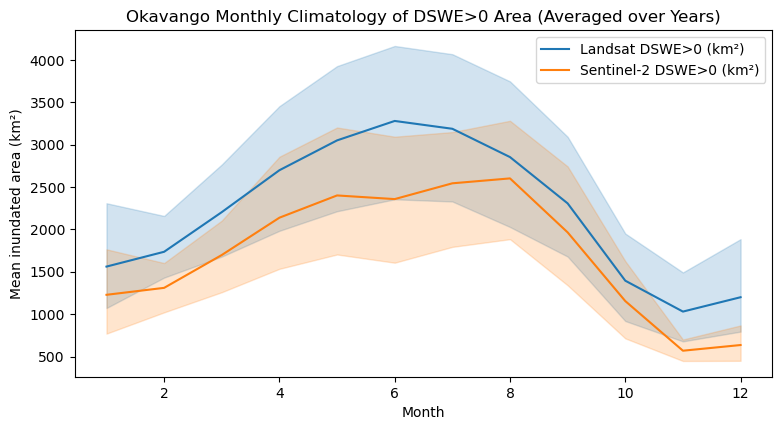

In [35]:
import calendar

import seaborn as sns
import warnings

def monthly_climatology(df: pd.DataFrame, sensor: str) -> pd.Series:
    """
    From a monthly df with columns ['date','count'], compute the mean DSWE>0 area (km²)
    for each calendar month (Jan..Dec) averaged across all years.
    sensor: 'landsat' or 'sentinel' (sentinel is scaled ÷9 to 30 m eq.)
    Returns a Series indexed 1..12 (month) with km² means.
    """
    out = df[['date','count']].copy()
    out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out = out.dropna(subset=['date'])
    if sensor == 'landsat':
        out['km2'] = out['count'] * PX30_TO_KM2
    elif sensor == 'sentinel':
        out['km2'] = (out['count'] / 9.0) * PX30_TO_KM2
    else:
        raise ValueError("sensor must be 'landsat' or 'sentinel'")
    out['month'] = out['date'].dt.month
    out['year'] = out['date'].dt.year    
    # average over all years per calendar month; NaNs are ignored by default
    return out.query('year > 2018')#.groupby('month')['km2'].mean().reindex(range(1,13))

# compute climatologies
ls_clim = monthly_climatology(df_ls, sensor='landsat')
s2_clim = monthly_climatology(df_s2, sensor='sentinel')

# make nice month labels
months = [calendar.month_abbr[m] for m in range(1, 13)]

warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*")
 
# plot (dashed lines with markers)
plt.figure(figsize=(9, 4.5))
sns.lineplot(ls_clim.query("year > 2018 and year != 2021"), x = 'month', y = 'km2',label='Landsat DSWE>0 (km²)')
sns.lineplot(s2_clim.query("year > 2018 and year != 2021").dropna(), x = 'month', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
plt.xlabel('Month'); plt.ylabel('Mean inundated area (km²)')
plt.title('Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')


# plt.figure(figsize=(9, 4.5))
# for year in range(2019, 2025):
#     sns.lineplot(ls_clim.query("year == {0}".format(year)), x = 'month', c = 'C0', y = 'km2',label='Landsat DSWE>0 (km²)')
#     sns.lineplot(s2_clim.query("year == {0}".format(year)).dropna(), x = 'month', c = 'C1', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
# plt.xlabel('Month'); plt.ylabel('Mean inundated area (km²)')
# plt.title('Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')
# plt.legend().set_visible(False)


Text(0.5, 1.0, 'Monthly inundated area in 2021')

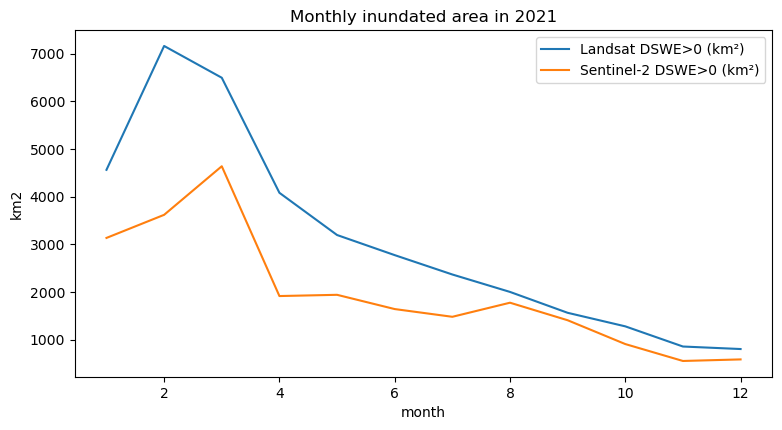

In [37]:
plt.figure(figsize=(9, 4.5))
sns.lineplot(ls_clim.query("year == 2021"), x = 'month', y = 'km2',label='Landsat DSWE>0 (km²)')
sns.lineplot(s2_clim.query("year == 2021").dropna(), x = 'month', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
plt.title('Monthly inundated area in 2021')

In [38]:

# what happened in 2021
# differenec between years
# seasonal cycle of DSWE == 3... various classes

In [39]:
# but also, maybe we'd like... 

In [40]:
import ee
import geemap.foliumap as geemap  # <-- folium backend (no jupyter-leaflet)
ee.Initialize()

year = '2019'


# helpers/vis
def dswe_jas_mean(ic, y):
    img = (ic.filter(ee.Filter.eq('year', y))
             .filter(ee.Filter.gte('month','07'))
             .filter(ee.Filter.lte('month','09'))
             .select(0)
             .mean().gt(0))
    return img.updateMask(img.gt(0))

vis_dswe_classes = {"palette": ['white','#deebf7','#9ecae1','#3182bd'], "min": 1, "max": 4}
vis_dswe_bin = {"palette": ['#9ecae1'], "min": 1, "max": 1}
vis_il = {"min": 0, "max": 1, "palette": ['#3182bd']}

# build images
il_year = IL_merged.filter(ee.Filter.eq('year', year)).mean().select(0)
il_year = il_year.updateMask(il_year.eq(1))
s2_jas  = dswe_jas_mean(s2_dswe, year)
ls_jas  = dswe_jas_mean(ls_dswe_collection,    year)

# folium map
m = geemap.Map()  # folium map
m.add_basemap('HYBRID')
m.addLayer(il_year, vis_il,               f'IL {year}')
m.addLayer(ls_jas,  vis_dswe_bin,     f'Landsat DSWE JAS {year}')


dswe_minus_il = ls_jas.unmask().subtract(il_year.unmask())
m.addLayer(dswe_minus_il.updateMask(dswe_minus_il.neq(0)),  vis_diff_rwb,     f'Landsat DSWE minus IL {year}')

m.addLayer(s2_jas,  vis_dswe_bin,     f'Sentinel-2 DSWE JAS {year}')
m.centerObject(okavango, 8)
m


In [41]:
# # import ee
# # import geemap.foliumap as geemap

# # ee.Initialize()

# year_start = 1991
# year_end   = 2019   # inclusive
# # okavango = ee.Geometry.Polygon(
# #     [[[21.7,-18.2],[21.7,-20.7],[24.1,-20.7],[24.1,-18.2],[21.7,-18.2]]],
# #     None, False
# # )

# # ImageCollections you already have
# #   IL_merged                -> IL annual maps (0=dry, 1/2=wet, 3=nodata)
# #   ls_dswe_collection       -> Landsat monthly DSWE with 'year','month','dswe' band
# # If your variables are named differently, adjust below.


# vis_frac = {  # sequential light→dark blues 0..1
#     "min": 0, "max": 1,
#     "palette": ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
# }
# vis_diff_rwb = {  # diverging -1..1
#     "min": -1, "max": 1,
#     "palette": ['#ef8a62','#f7f7f7','#67a9cf']
# }


# def years_list(y0, y1):
#     return ee.List.sequence(y0, y1).map(lambda y: ee.String(ee.Number(y).format('%d')))

# def landsat_wet_valid_for_year(ic, y_str):
#     """Return 2-band image for a given year: wet(0/1), valid(0/1) for JAS DSWE."""
#     img = (ic.filter(ee.Filter.eq('year', y_str))
#              .filter(ee.Filter.gte('month', '07'))
#              .filter(ee.Filter.lte('month', '09'))
#              .select('dswe')
#              .mean())
#     # wet if DSWE>0
#     wet = img.gt(0).rename('wet')
#     # valid if any JAS observation existed at that pixel (use the mask of the mean)
#     valid = img.mask().gt(0).rename('valid')
#     # make both bands share the same mask = valid
#     wet = wet.updateMask(valid)
#     valid = valid.updateMask(valid)
#     return wet.addBands(valid)

# def il_wet_valid(img):
#     """Map over IL images: make wet(0/1) and valid(0/1) bands.
#        IL codes assumed: 0=dry, 1/2=wet, 3=nodata."""
#     il = img.select(0).rename('il_raw')
#     wet   = il.eq(1).Or(il.eq(2)).rename('wet')
#     valid = il.neq(3).rename('valid')
#     wet   = wet.updateMask(valid)
#     valid = valid.updateMask(valid)
#     return wet.addBands(valid).copyProperties(img, ['year'])

# # -------------------------
# # Build IL fraction-of-years map
# # -------------------------
# ys = years_list(year_start, year_end)

# il_range = ee.ImageCollection(IL_merged) \
#     .filter(ee.Filter.gte('year', ee.String(str(year_start)))) \
#     .filter(ee.Filter.lte('year', ee.String(str(year_end)))) \
#     .map(il_wet_valid)

# il_wet_sum   = il_range.select('wet').sum()
# il_valid_sum = il_range.select('valid').sum()  # number of years with valid IL data per pixel
# il_frac      = il_wet_sum.divide(il_valid_sum).rename('il_frac')

# # -------------------------
# # Landsat fraction-of-years map (JAS)
# # -------------------------
# def ls_year_img(y_str):
#     return landsat_wet_valid_for_year(ls_dswe_collection, y_str)

# ls_range = ee.ImageCollection(ys.map(lambda y: ls_year_img(ee.String(y))))
# ls_wet_sum   = ls_range.select('wet').sum()
# ls_valid_sum = ls_range.select('valid').sum()
# ls_frac      = ls_wet_sum.divide(ls_valid_sum).rename('ls_frac')
# # -------------------------
# # Difference (Landsat − IL)
# # -------------------------
# diff_frac = ls_frac.subtract(il_frac).rename('diff_frac')


# m = geemap.Map()
# m.add_basemap('HYBRID')

# m.addLayer(il_frac.selfMask(), vis_frac, f'IL fraction wet {year_start}-{year_end}')
# m.addLayer(ls_frac.selfMask(), vis_frac, f'Landsat DSWE fraction wet (JAS) {year_start}-{year_end}')
# # m.addLayer(diff_frac.clip(okavango), vis_diff_rwb, 'Landsat − IL (fraction)')

# m.centerObject(okavango, 8)
# m


In [43]:
year_start = 1991
year_end   = 2019   # inclusive


vis_frac = {  # sequential 0..1
    "min": 0, "max": 1,
    "palette": ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
}
vis_diff_rwb = {"min": -1, "max": 1, "palette": ['#ef8a62','#f7f7f7','#67a9cf']}

def years_list(y0, y1):
    return ee.List.sequence(y0, y1).map(lambda y: ee.String(ee.Number(y).format('%d')))

def landsat_wet_valid_for_year(ic, y_str):
    """Return 2-band image for a year: wet(0/1), valid(0/1) for JAS DSWE; fully masked if no data."""
    sub = (ic.filter(ee.Filter.eq('year', y_str))
             .filter(ee.Filter.gte('month', '07'))
             .filter(ee.Filter.lte('month', '09')))
    size = sub.size()

    # compute when we DO have images
    img   = sub.select('dswe').mean()                          # may be 0-band if size==0
    wet   = img.gt(0).rename('wet')
    valid = img.mask().gt(0).rename('valid')
    out   = wet.updateMask(valid).addBands(valid.updateMask(valid))

    # fallback: return fully masked 2-band image (wet, valid)
    empty = ee.Image.constant([0,0]).rename(['wet','valid']).updateMask(ee.Image(0))

    return ee.Image(ee.Algorithms.If(size.gt(0), out, empty))

def il_wet_valid(img):
    """IL codes: 0=dry, 1/2=wet, 3=nodata -> wet + valid bands."""
    il    = img.select(0).rename('il_raw')
    wet   = il.eq(1).rename('wet')
    valid = il.neq(3).rename('valid')
    wet   = wet.updateMask(valid)
    valid = valid.updateMask(valid)
    
    return wet.addBands(valid).copyProperties(img, ['year'])

# ---------- IL fraction-of-years ----------
ys = years_list(year_start, year_end)

il_range = (IL_merged
            .filter(ee.Filter.gte('year', ee.String(str(year_start))))
            .filter(ee.Filter.lte('year', ee.String(str(year_end))))
            .map(il_wet_valid))

il_wet_sum   = il_range.select('wet').sum()
il_valid_sum = il_range.select('valid').sum()
il_frac      = il_wet_sum.divide(il_valid_sum).rename('il_frac')

# ---------- Landsat fraction-of-years (JAS) ----------
def ls_year_img(y_str):
    return landsat_wet_valid_for_year(ls_dswe_collection, y_str)

ls_range     = ee.ImageCollection(ys.map(lambda y: ls_year_img(ee.String(y))))
ls_wet_sum   = ls_range.select('wet').sum()
ls_valid_sum = ls_range.select('valid').sum()
ls_frac      = ls_wet_sum.divide(ls_valid_sum).rename('ls_frac')

# ---------- Difference ----------
diff_frac = ls_frac.unmask().subtract(il_frac.unmask()).rename('diff_frac')


m = geemap.Map()
m.add_basemap('HYBRID')

m.addLayer(il_frac.selfMask().clip(okavango), vis_frac, f'IL fraction wet {year_start}-{year_end}')
m.addLayer(ls_frac.selfMask().clip(okavango), vis_frac, f'Landsat DSWE fraction wet (JAS) {year_start}-{year_end}')
m.addLayer(diff_frac.clip(okavango), vis_diff_rwb, 'Landsat − IL (fraction)')

m.centerObject(okavango, 8)
m


In [82]:
import ee
import geemap.foliumap as geemap

ee.Initialize()

# ---- params ----
year_start = 1991
year_end   = 2019   # inclusive


# ---- viz ----
vis_months = {  # mean # of wet months in JAS (0..3)
    "min": 0, "max": 12,
    "palette": ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
}

def years_list(y0, y1):
    return ee.List.sequence(y0, y1).map(lambda y: ee.String(ee.Number(y).format('%d')))

DSWE_BAND = ee.String(ls_dswe_collection.first().bandNames().get(0))  # use whatever band name is first

def landsat_month_wet_or_mask(ic, year_str, month_str):
    """
    Return 'wet' (0/1) for (year, month). Robust to string/number props and band name differences.
    """
    y_num = ee.Number.parse(year_str)
    m_num = ee.Number.parse(month_str)

    f_year  = ee.Filter.Or(ee.Filter.eq('year', year_str),  ee.Filter.eq('year', y_num))
    f_month = ee.Filter.Or(ee.Filter.eq('month', month_str), ee.Filter.eq('month', m_num))

    sub = ic.filter(f_year).filter(f_month)
    size = sub.size()

    mean_dswe = sub.select([DSWE_BAND]).mean()   # monthly mean of the DSWE band (whatever it's called)
    wet   = mean_dswe.gt(0).rename('wet')
    valid = mean_dswe.mask().gt(0)
    wet   = wet.updateMask(valid)                # mask where no valid data for this month

    empty = ee.Image.constant(0).rename('wet').updateMask(ee.Image(0))  # fully masked if month empty
    return ee.Image(ee.Algorithms.If(size.gt(0), wet, empty))

def landsat_wet_months_for_year(ic, year_str):
    """Sum wet months for Jan..Dec (0..12); unmask to 0 so yearly images always have a value."""
    months = ee.List.sequence(1, 12).map(lambda m: ee.String(ee.Number(m).format('%02d')))
    ic12 = ee.ImageCollection(months.map(lambda m: landsat_month_wet_or_mask(ic, year_str, ee.String(m))))
    return ic12.sum().rename('wet_months').unmask(0)  # <= key: unmask yearly sum


# ---- build Landsat: mean # wet months across years  ----
ys = years_list(year_start, year_end)
ls_yearly_wetmonths = ee.ImageCollection(ys.map(lambda y: landsat_wet_months_for_year(ls_dswe_collection, ee.String(y))))

# Average across years; pixels with no valid JAS months in a year are masked that year (excluded from mean)
ls_mean_months = ls_yearly_wetmonths.mean().rename('ls_mean_wet_months') 

test = landsat_wet_months_for_year(ls_dswe_collection, '2019')
# test = ls_dswe_collection.first().select(0).gt(0)
print (test.getInfo())



import folium

# --- Horizontal gradient legend for "wet months" (0–12) ---
palette = vis_months['palette']
vmin = vis_months.get('min', 0)
vmax = vis_months.get('max', 12)
label = 'Wet months per year'

# Build CSS gradient stops left→right
stops = ','.join([f'{c} {int(i*100/(len(palette)-1))}%' for i, c in enumerate(palette)])

# Choose evenly spaced tick labels (0, 3, 6, 9, 12)
ticks = [vmin, vmin + (vmax-vmin)*0.25, vmin + (vmax-vmin)*0.5, vmin + (vmax-vmin)*0.75, vmax]
tick_html = ''.join(f'<span>{t:.0f}</span>' for t in ticks)

legend_html = f"""
<div style="
  position: fixed;
  bottom: 20px; right: 20px;
  z-index: 9999;
  background: rgba(0,0,0,0.45);
  padding: 12px 14px;
  border-radius: 12px;
  color: white;                 /* white font */
  font-size: 16px;              /* larger font */
  line-height: 1.2;
  min-width: 320px;">
  <div style="margin-bottom:10px; font-weight:600;">{label}</div>
  <div style="display:flex; flex-direction:column; gap:8px;">
    <div style="
      width: 320px; height: 16px;
      background: linear-gradient(to right, {stops});
      border-radius: 6px;"></div>
    <div style="display:flex; justify-content:space-between;">
      {tick_html}
    </div>
  </div>
</div>
"""

m = geemap.Map()
m.add_basemap('HYBRID')

m.addLayer(ls_yearly_wetmonths.first().clip(okavango), vis_months,
           f'Landsat DSWE: mean # wet months ({year_start}-{year_end})')
m.get_root().html.add_child(folium.Element(legend_html))

m.centerObject(okavango, 8)
m


{'type': 'Image', 'bands': [{'id': 'wet_months', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -9.223372036854776e+18, 'max': 9.223372036854776e+18}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [77]:
import geemap.foliumap as geemap  

m = geemap.Map()
m.add_basemap('HYBRID')

m.addLayer(il_frac.clip(okavango), vis_frac, 'IL fraction wet')
m.addLayer(ls_frac.clip(okavango), vis_frac, 'Landsat DSWE fraction wet (JAS)')

# Add a continuous legend (uses vis_frac's min/max/palette)
m.add_colorbar(vis_params=vis_frac, label='Fraction wet (0–1)', fontsize = 12, fontcolor = 'white')

# Add layer toggle and center
m.add_layer_control()
m.centerObject(okavango, 8)

m


In [83]:
import geemap.foliumap as geemap
import folium

m = geemap.Map()
m.add_basemap('HYBRID')

# Example: add your layers clipped to the shapefile boundary
m.addLayer(il_frac.clip(okavango), vis_frac, 'IL fraction wet')
m.addLayer(ls_frac.clip(okavango), vis_frac, 'Landsat DSWE fraction wet (JAS)')

# Example: add your layers clipped to the shapefile boundary
m.addLayer(il_frac.clip(okavango), vis_frac, 'IL fraction wet')
m.addLayer(ls_frac.updateMask(ls_frac.neq(0)).clip(okavango), vis_frac, 'Landsat DSWE fraction wet (JAS)')

# --- Styled gradient legend (white text, larger font) ---
palette = vis_frac['palette']
vmin = vis_frac.get('min', 0)
vmax = vis_frac.get('max', 1)
label = 'Fraction wet (0–1)'

# Build CSS gradient stops
stops = ','.join([f'{c} {int(i*100/(len(palette)-1))}%' for i, c in enumerate(palette)])

legend_html = f"""
<div style="
  position: fixed;
  bottom: 20px; right: 20px;
  z-index: 9999;
  background: rgba(0,0,0,0.45);
  padding: 10px 12px;
  border-radius: 10px;
  color: white;                /* ← white font */
  font-size: 16px;             /* ← larger font */
  line-height: 1.2;">
  <div style="margin-bottom:8px; font-weight:600;">{label}</div>
  <div style="display:flex; align-items:flex-end; gap:10px;">
    <div style="width: 16px; height: 160px; 
                background: linear-gradient(to top, {stops});
                border-radius: 4px;"></div>
    <div style="display:flex; flex-direction:column; justify-content:space-between; height:160px;">
      <span>{vmax}</span>
      <span style="opacity:0.8">{(vmin+vmax)/2:.2f}</span>
      <span>{vmin}</span>
    </div>
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Controls + view
m.add_layer_control()
m.centerObject(okavango, 8)
m


# Controls + view
m.add_layer_control()
m.centerObject(okavango, 8)
m
